In [1]:
import tensorflow as tf
# current processing

tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'))


# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#             logical_gpus = tf.config.list_logical_devices('GPU')
#             print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#         print(e)

from importlib import import_module
import keras
from keras.api._v2 import keras as KerasAPI
keras: KerasAPI = import_module("tensorflow.keras")
print(tf.__version__)

from keras import models, layers
from keras.models import Sequential
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter

from PIL import Image, ImageChops, ImageEnhance
import itertools
import os
import random

import time
import itertools
import shutil
import cv2
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

2.10.0


In [2]:
path = ''
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/deepLearningAs3/'

# dataset = 'CASIA2'
dataset = 'CASIA1'
pathfinal = path + f'model_history/{dataset}/'
pathfinal2 = path + 'model_images/'

dir = f'{path + dataset}'
interval = 1
epoch = 100

casio2_data =  path+'CASIA2_processed_data'
casio1_data =  path+'CASIA1_processed_data'

global_random_state = 42
image_size = (224, 224)
np.random.seed(global_random_state)
checkpoint_path = ''

In [3]:
def delete_folder_contents(path_erase):
    '''
    take path to erase all data present on it
    '''
    folder_name = path_erase
    # Get all files in the folder
    files = os.listdir(folder_name)

    # Loop through the files and delete them
    for file in files:
        file_path = os.path.join(folder_name, file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")
            
# delete_folder_contents(pathfinal)
# delete_folder_contents(pathfinal2)

In [4]:
def convert_to_ELA_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    # Remove the temporary compressed image
    image.close()
    temp_image.close()
    
    return ela_image

def prepare_image(image_path):
    return np.array(convert_to_ELA_image(image_path, 90).resize(image_size)) / 255.0

Open a real image

CASIA1/Au/Au_ani_0044.jpg


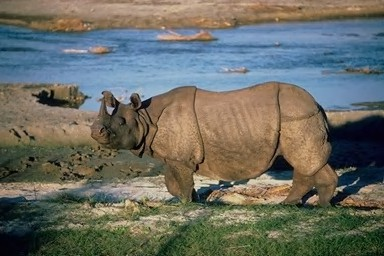

In [5]:
real_image_path = f'{dir}/Au/{os.listdir(f"{dir}/Au/")[14]}'
print(real_image_path)
Image.open(real_image_path)

After converting to ELA image

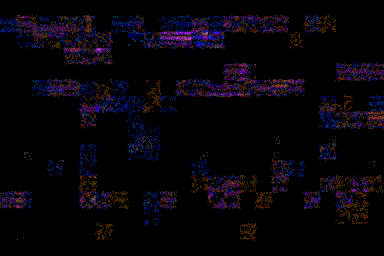

In [6]:
convert_to_ELA_image(real_image_path, 90)

Open a fake image

CASIA1/Tp/Sp_D_NND_A_nat0031_nat0096_0610.jpg


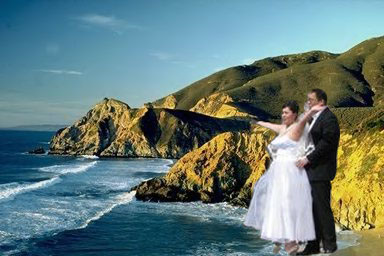

In [7]:
fake_image_path = f'{dir}/Tp/{os.listdir(f"{dir}/Tp/")[24]}'
print(fake_image_path)
Image.open(fake_image_path)

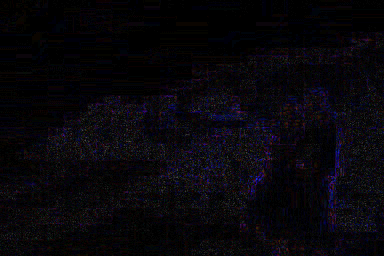

In [8]:
convert_to_ELA_image(fake_image_path, 90)

Dataset Preparation

In [9]:
%%script echo "skipped"

X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

path = f'{dir}/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append([1, 1])
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

path = f'{dir}/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            
            if(filename[3] == 'D'):
                Y.append([0, 1]) # 1 for different
            else: # S
                Y.append([0, 0]) # 0 for same
            
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

X = np.array(X)

# Train Test split with 80:20 ratio
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=global_random_state)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

skipped


In [10]:
# %%script echo "skipped"

# np.save(casio2_data + '/X_train', X_train)
# np.save(casio2_data + '/X_val', X_val)
# np.save(casio2_data + '/Y_train', Y_train)
# np.save(casio2_data + '/Y_val', Y_val)

# X_train = np.load(casio2_data + '/X_train.npy')
# X_val = np.load(casio2_data + '/X_val.npy')
# Y_train_t = np.load(casio2_data + '/Y_train.npy')
# Y_val_t = np.load(casio2_data + '/Y_val.npy')

# Y_train = Y_train_t[:, 0]
# Y_val = Y_val_t[:, 0]

In [11]:
# %%script echo "skipped"

# np.save(casio1_data + '/X_train', X_train)
# np.save(casio1_data + '/X_val', X_val)
# np.save(casio1_data + '/Y_train', Y_train)
# np.save(casio1_data + '/Y_val', Y_val)

X_train = np.load(casio1_data + '/X_train.npy')
X_val = np.load(casio1_data + '/X_val.npy')
Y_train_t = np.load(casio1_data + '/Y_train.npy')
Y_val_t = np.load(casio1_data + '/Y_val.npy')

Y_train = Y_train_t[:, 0]
Y_val = Y_val_t[:, 0]

### Inference functions

In [12]:
def inferences(df_model_history, model):
    # print('\n\n')
    # print(f'Training Accuracy for model: {df_model_history["accuracy"].to_list()[-1]*100:.2f}%')
    # print(f'Validation Accuracy for model: {df_model_history["val_accuracy"].to_list()[-1]*100:.2f}%')
    # print(f'Test Accuracy for model: {model.evaluate(test_data, verbose=0)[1]*100:.2f}%')i

    df_model_history.plot(title="Accuracy / Loss vs Epoch", xlabel='Epoch', ylabel='Accuracy / Loss')
    plt.show()

    # Plot the loss and accuracy curves for training and validation 
    fig, ax = plt.subplots(2,1)
    ax[0].plot(df_model_history['loss'], color='b', label="Training loss")
    ax[0].plot(df_model_history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(df_model_history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(df_model_history['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    


### Callbacks


In [13]:
class ModelSaving(keras.callbacks.Callback):
    def __init__(self, interval=1e9):
        self.currentEpoch = 0
        self.interval = interval
        
    def on_epoch_end(self, epoch, logs=None):
        self.currentEpoch = epoch
        if(self.currentEpoch%self.interval == 0):
            self.model.save(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.tf')

    def on_train_end(self, logs=None):
        self.model.save(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.tf')
        # print("Training has ended!, model saved")

    
class HistorySaver(keras.callbacks.Callback):
    def __init__(self, initial_history, interval=1e9):
        super(HistorySaver, self).__init__()
        self.history = {}
        self.currentEpoch = 0
        self.interval = interval
        for key, value in [('loss', initial_history[0]), ('accuracy', initial_history[1]), ('val_loss', initial_history[2]), ('val_accuracy', initial_history[3])]:
            self.history.setdefault(key, []).append(value)
        
        # logs.items() = dict_items([('loss', 1.3612865209579468), ('accuracy', 0.46034255623817444), ('val_loss', 1.1157031059265137), ('val_accuracy', 0.6484848856925964)])
    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)
        self.currentEpoch = epoch

        if(self.currentEpoch%self.interval == 0):
            pd.DataFrame(self.history).to_csv(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.csv', index=False)

        
    def on_train_end(self, logs=None):
        pd.DataFrame(self.history).to_csv(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.csv', index=False)
        # print("Training has ended!, model history saved")



# create the callbacks

model_saver = ModelSaving(interval)

# This means if for 15 epochs the accuracy has no progress on 
# the validation set then it would stop and store the previous best value.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=15,
                                                  min_delta=1e-4,
                                                  mode='min',
                                                  restore_best_weights=False, 
                                                  verbose=1)

checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         save_freq="epoch") # save the model weights which score the best validation accuracy) 

### CNN Model

Total number of parameters: 105826


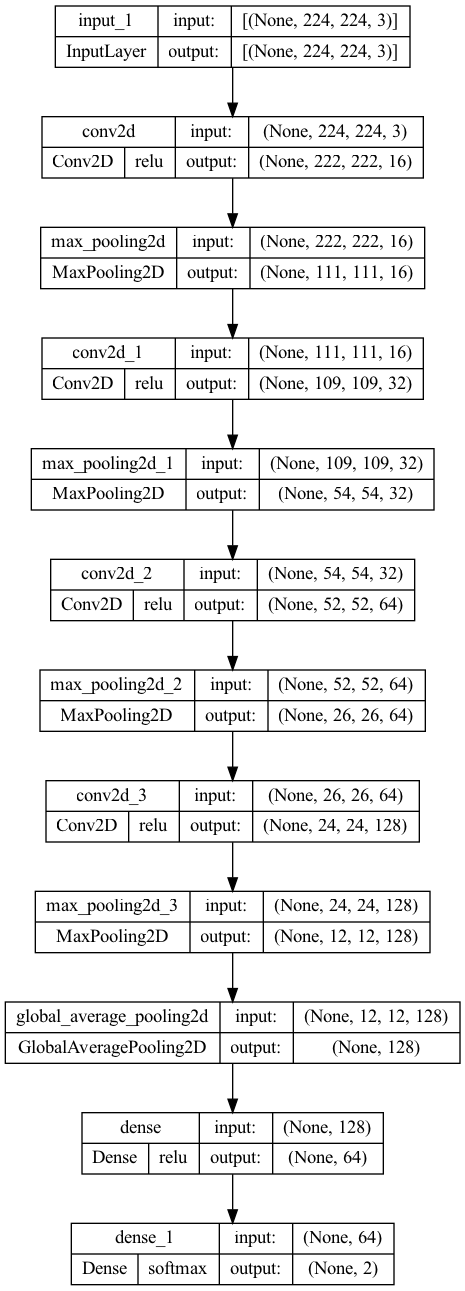

In [14]:
# Define the model
def build_model():
    model = Sequential()

    # Stage 1: Preprocessing (Resize image)
    # You can add a preprocessing layer to resize the input image to the desired size
    model.add(layers.Input(shape=(224, 224, 3)))  # Adjust the input shape as needed

    # Stage 2: Feature Extraction
    # First Convolutional Layer
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Convolutional Layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Fourth Convolutional Layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.GlobalAveragePooling2D())

    # Stage 3: Classification
    # Fully Connected Layer
    model.add(layers.Dense(64, activation='relu')) # added
    model.add(layers.Dense(2, activation='softmax')) # 2 classes (authentic or forgery)

    return model



model = build_model()
# model.summary()
total_parameters = model.count_params()
print(f"Total number of parameters: {total_parameters}")
plot_model(model,to_file=f'{pathfinal2}/model.png', show_shapes=True, show_layer_activations=True, expand_nested=True)

In [15]:
batch_size = 32
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr, decay = init_lr/epoch)
model.compile(optimizer = 'adam', loss = 'SparseCategoricalCrossentropy', metrics = ['accuracy'])

### Model fit

In [16]:
%%script echo "skipped"

# Evaluate the model initial losses
initial_train_loss, initial_train_acc = model.evaluate(X_train, Y_train, verbose=0)
initial_valid_loss, initial_valid_acc = model.evaluate(X_val, Y_val, verbose=0)

# Fit the model
hist = model.fit(X_train, Y_train,
                        batch_size = batch_size,
                        epochs=epoch,
                        validation_data=(X_val, Y_val),
                        callbacks=[model_saver, 
                                   HistorySaver((initial_train_loss, initial_train_acc, initial_valid_loss, initial_valid_acc), interval), 
                                   early_stopping_cb],
                        verbose=1)

df_history = pd.DataFrame(hist.history)

skipped


In [17]:
# %%script echo "skipped"

df_history = pd.read_csv('savedModel/C1sequential_2_100.csv')
model.load_weights('savedModel/C1sequential_2_100.tf')

2023-09-17 17:28:35.214477: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open C1sequential_2_100.tf: FAILED_PRECONDITION: C1sequential_2_100.tf; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [18]:
class_names = ['Fake', 'Real']

def prediction(model, X, Y):
    # Predict the values from the validation dataset
    Y_pred = model.predict(X, verbose=0)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y, Y_pred_classes) 
    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes = class_names)
    accuracy = accuracy_score(Y, Y_pred_classes)
    print(f"Accuracy: {accuracy*100 : .2f} %")

def prediction_on_one_image(model, image_path):
    image = prepare_image(image_path)
    image = image.reshape(-1, image_size[0], image_size[0], 3)
    y_pred = model.predict(image)
    print(y_pred)
    y_pred_class = np.argmax(y_pred, axis = 1)[0]
    print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

### Inferences

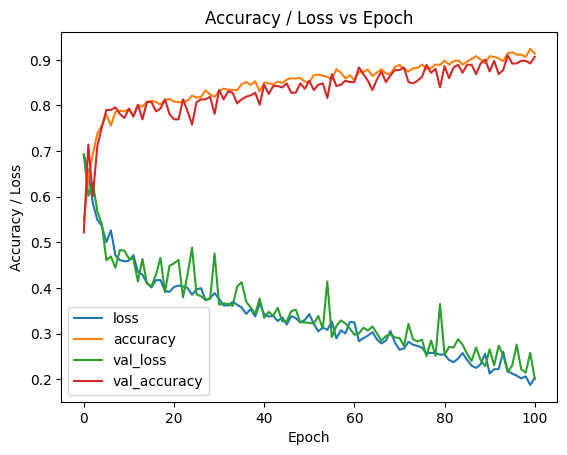

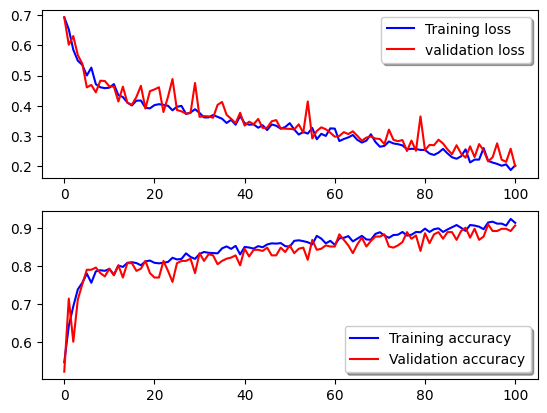

In [19]:
inferences(df_history, model)

## On Train set

2023-09-17 17:28:36.255999: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Accuracy:  92.84 %


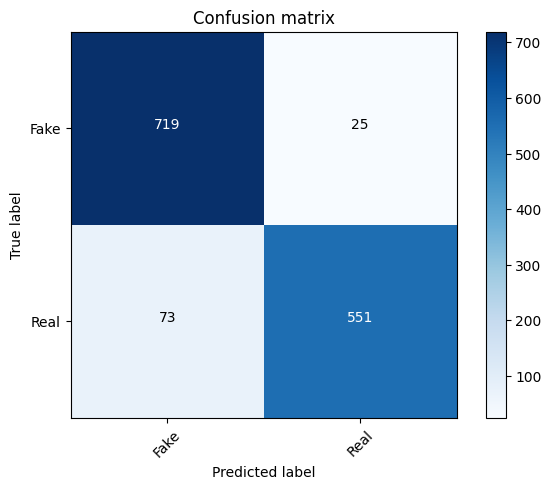

In [20]:
prediction(model, X_train, Y_train)

## On Validation set

Accuracy:  90.67 %


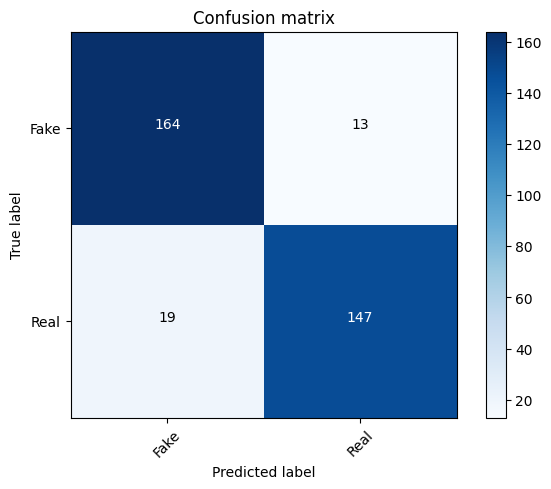

In [21]:
prediction(model, X_val, Y_val)

Prediction

In [22]:
prediction_on_one_image(model, real_image_path)
prediction_on_one_image(model, fake_image_path)

1/1 [==============================] - 0s 16ms/step
[[1.1949218e-09 1.0000000e+00]]
Class: Real Confidence: 100.00
1/1 [==============================] - 0s 23ms/step
[[9.9968982e-01 3.1025923e-04]]
Class: Fake Confidence: 99.97


### Analysis

In [23]:
def countA(arr, l):
    c=0
    for i in range(len(arr)):
        if(arr[i][0] == l[0] and arr[i][1] == l[1]):
            c+=1
    return c

print('TRAINING DATA')
print(f'Total Examples: {len(X_train)}')
print(f'Real Images: {np.count_nonzero(Y_train == 1)}')
print(f'Fake Images: {np.count_nonzero(Y_train == 0)} = {countA(Y_train_t, [0, 0])} same + {countA(Y_train_t, [0, 1])} different')

print()
print('VALIDATION DATA')
print(f'Total Examples: {len(X_val)}')
print(f'Real Images: {np.count_nonzero(Y_val == 1)}')
print(f'Fake Images: {np.count_nonzero(Y_val == 0)} = {countA(Y_val_t, [0, 0])} same + {countA(Y_val_t, [0, 1])} different')

TRAINING DATA
Total Examples: 1368
Real Images: 624
Fake Images: 744 = 370 same + 374 different

VALIDATION DATA
Total Examples: 343
Real Images: 166
Fake Images: 177 = 89 same + 88 different


In [24]:
X_val_real = []
Y_val_real = []

X_val_fake_same = []
Y_val_fake_same = []

X_val_fake_different = []
Y_val_fake_different = []

def data_split(X_val, Y_val_t, Y_val):
    for i in range(len(X_val)):
        if(Y_val_t[i][0] == 1): # real
            X_val_real.append(X_val[i])
            Y_val_real.append(Y_val[i])
        else:
            if(Y_val_t[i][1] == 0): # fake same
                X_val_fake_same.append(X_val[i])
                Y_val_fake_same.append(Y_val[i])
            else: # fake different
                X_val_fake_different.append(X_val[i])
                Y_val_fake_different.append(Y_val[i])

data_split(X_val, Y_val_t, Y_val)
X_val_real = np.array(X_val_real)
Y_val_real = np.array(Y_val_real)
X_val_fake_same = np.array(X_val_fake_same)
Y_val_fake_same = np.array(Y_val_fake_same)
X_val_fake_different = np.array(X_val_fake_different)
Y_val_fake_different = np.array(Y_val_fake_different)

### Real Images Validation Set

Accuracy:  88.55 %


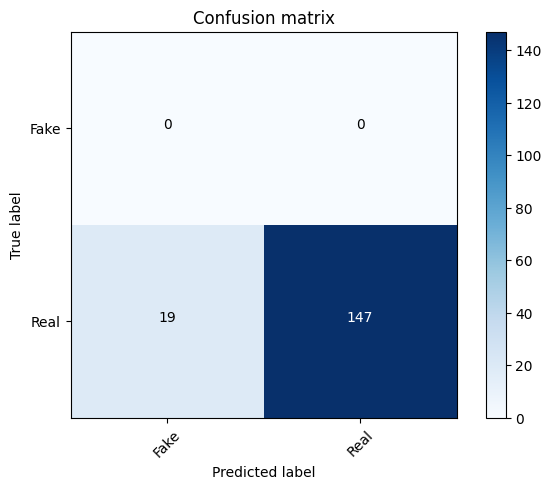

In [25]:
prediction(model, X_val_real, Y_val_real)

### Fake Images Copy-Move Validation Set

Accuracy:  92.13 %


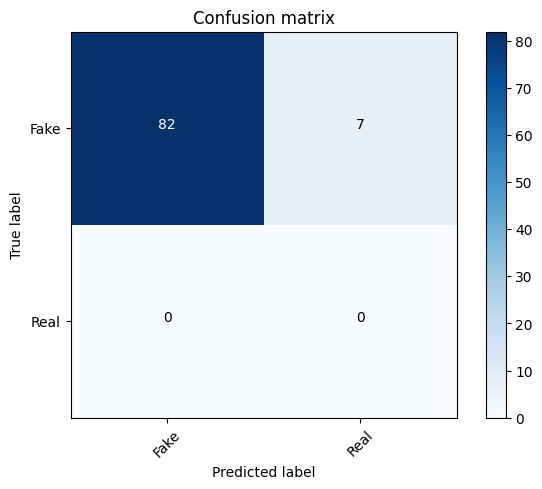

In [26]:
prediction(model, X_val_fake_same, Y_val_fake_same)

### Fake Images Splicing Validation Set

Accuracy:  93.18 %


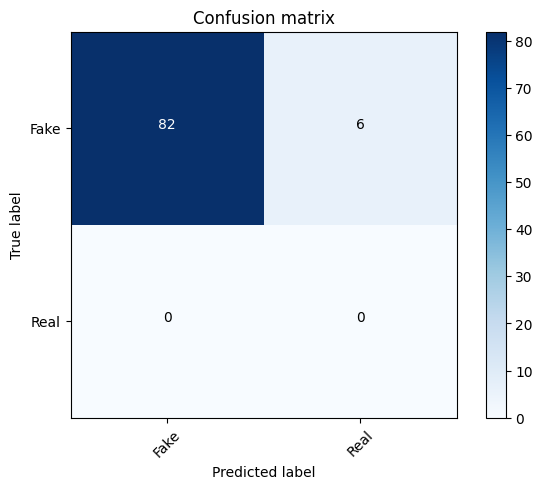

In [27]:
prediction(model, X_val_fake_different, Y_val_fake_different)